In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LocallyConnected1D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Conv1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf
import cv2

from sklearn.metrics import jaccard_score
from tensorflow.keras.datasets import mnist
import math

Loading the data

In [35]:
# functions

def loadNumpyArray(filename):
    return np.load(filename+'.npy')

def jaccardSimilarity(mask1,mask2):
    return jaccard_score(mask1.ravel(),mask2.ravel())

def dis(i,j,x,y):
    return math.sqrt((i-x)**2 + (j-y)**2)

def computeMask(cenrad,max_coord,max_radius):
    x = cenrad[0]*max_coord
    y = cenrad[1]*max_coord
    rad = cenrad[2]*max_radius*2
    
    mask = np.zeros((28,28))
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if dis(i,j,x,y) <= rad:
                mask[i][j]=1
    return mask
            

In [18]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('Loading the data from 1.2')
cenrad_trainX=loadNumpyArray('q3dataset_cen_rad_train')
cenrad_testX = loadNumpyArray('q3dataset_cen_rad_test')


print('Showing some stats for the data..')
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))


Loading the data from 1.2
Showing some stats for the data..
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


Preparing the data

In [19]:
# Set some parameters
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
OUTPUT_CHANNELS = 1
MODEL_NAME = 'modelq3.h5'

NO_OF_OUTPUT_CLASSSES =10
# OUTPUT_SIZE = NO_OF_OUTPUT_CLASSSES + 3 # x,y,radius
OUTPUT_SIZE = NO_OF_OUTPUT_CLASSSES # x,y,radius

MAX_COORD = 28
MAX_RADIUS = 14 * math.sqrt(2) #28/2

seed = 42
random.seed = seed
np.random.seed = seed

print("Preparing the data")

no_of_samples = train_X.shape[0]
X_train = np.zeros((no_of_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((no_of_samples, IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=np.bool)
Y_train_label = np.zeros((no_of_samples,OUTPUT_SIZE))
Y_train_cenrad = cenrad_trainX
Y_train_cenrad[:,:-1] = Y_train_cenrad[:,:-1]/ MAX_COORD
Y_train_cenrad[:,-1] = Y_train_cenrad[:,-1] / MAX_RADIUS


print("X_train",X_train.shape)
print("Y_train for label",Y_train_label.shape)
print("Y_train for bbox",Y_train_cenrad.shape)

for i in range(no_of_samples):
    X_train[i,:,:,0] = train_X[i,:,:]
    Y_train_label[i,train_y[i]] = 1 

# test data
test_samples_no = test_X.shape[0]
X_test = np.zeros((test_samples_no, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_test = np.zeros((test_samples_no, IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS), dtype=np.bool)
# Y_test = np.zeros((test_samples_no, 1,1,OUTPUT_SIZE))
Y_test_label = np.zeros((test_samples_no,OUTPUT_SIZE))
Y_test_cenrad = cenrad_testX
Y_test_cenrad[:,:-1] = Y_test_cenrad[:,:-1]/ MAX_COORD
Y_test_cenrad[:,-1] = Y_test_cenrad[:,-1] / MAX_RADIUS

for i in range(test_samples_no):
    X_test[i,:,:,0] = test_X[i,:,:]
    Y_test_label[i,test_y[i]] = 1

print('Showing some stats for the data..')
print('X_train: ' + str(X_train.shape))
print('Y_train label: ' + str(Y_train_label.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test label:  '  + str(Y_test_label.shape))
print('Done!')

Preparing the data
X_train (60000, 28, 28, 1)
Y_train for label (60000, 10)
Y_train for bbox (60000, 3)
Showing some stats for the data..
X_train: (60000, 28, 28, 1)
Y_train label: (60000, 10)
X_test:  (10000, 28, 28, 1)
Y_test label:  (10000, 10)
Done!


Defining the model

In [20]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
x = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
x = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
x = MaxPooling2D((2,2))(x)
# x = Conv2D(32, (3,3), activation='relu')(x)
# x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
x = Conv2D(128, (2,2), activation='elu', kernel_initializer='he_normal', padding='same')(x)

# u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)
# # u8 = concatenate([u8, c2])
# c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
# c8 = Dropout(0.1) (c8)
# x = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
# c9 = Dropout(0.1) (c9)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)





x = GlobalAveragePooling2D()(x)

# classifier_head = Dropout(0.3)(x)
classifier_head = Dense(64, activation='relu')(x)
classifier_head = Dense(32, activation='relu')(classifier_head)
classifier_head = Dense(10, activation='softmax', name='label')(classifier_head)

reg_head = Dense(64, activation='relu')(x)
# reg_head = Dense(32, activation='relu')(reg_head)
reg_head = Dense(3, activation='sigmoid', name='bbox')(reg_head)

model = Model(inputs=[inputs], outputs=[classifier_head, reg_head])

losses = {'label': 'categorical_crossentropy',
          'bbox': 'mse'}

loss_weights = {'label': 1.0,
                'bbox': 1.0}

model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc','mse'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 28, 28, 1)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 28, 28, 32)   320         lambda_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_24[0][0]                  
____________________________________________________________________________________________

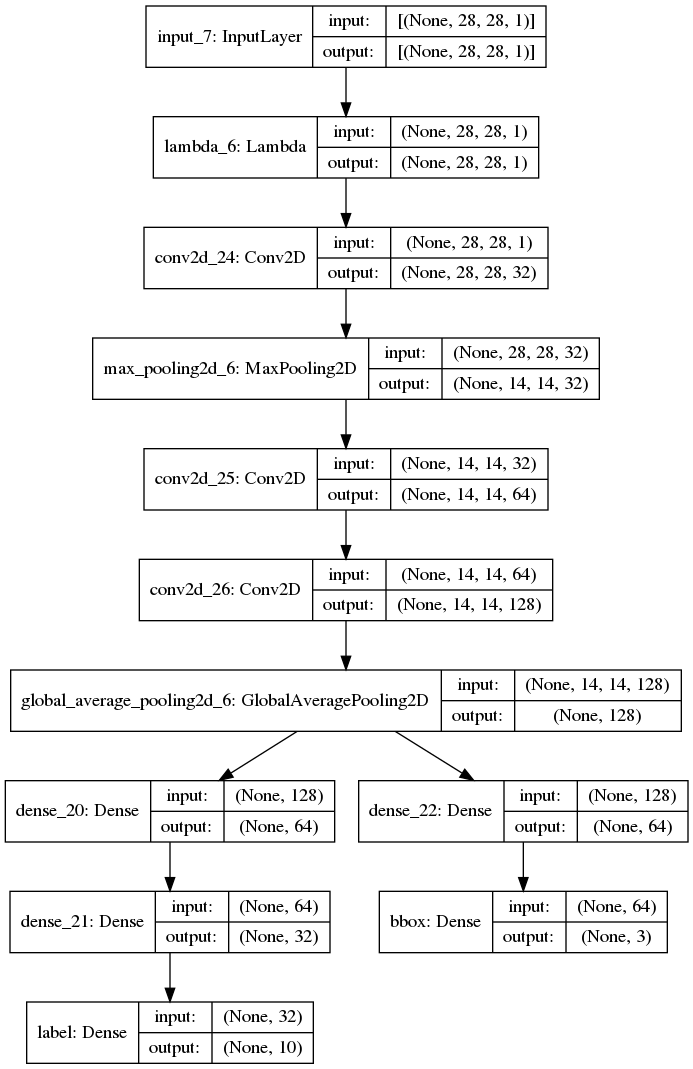

In [21]:
tf.keras.utils.plot_model(
    model, to_file='q3model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

training the model

In [22]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(MODEL_NAME, verbose=1, save_best_only=True)
epochs =  15
results = model.fit(X_train, [Y_train_label, Y_train_cenrad], validation_split=0.1, batch_size=16, epochs=epochs,callbacks=[earlystopper, checkpointer])


Epoch 1/15
3375/3375 [==============================] - 60s 18ms/step - loss: 0.9941 - label_loss: 0.9910 - bbox_loss: 0.0031 - label_acc: 0.6444 - label_mse: 0.0427 - bbox_acc: 0.5855 - bbox_mse: 0.0031 - val_loss: 0.1376 - val_label_loss: 0.1346 - val_bbox_loss: 0.0030 - val_label_acc: 0.9600 - val_label_mse: 0.0060 - val_bbox_acc: 0.7125 - val_bbox_mse: 0.0030

Epoch 00001: val_loss improved from inf to 0.13758, saving model to modelq3.h5
Epoch 2/15
3375/3375 [==============================] - 63s 19ms/step - loss: 0.1601 - label_loss: 0.1577 - bbox_loss: 0.0024 - label_acc: 0.9511 - label_mse: 0.0075 - bbox_acc: 0.7080 - bbox_mse: 0.0024 - val_loss: 0.0756 - val_label_loss: 0.0727 - val_bbox_loss: 0.0029 - val_label_acc: 0.9777 - val_label_mse: 0.0033 - val_bbox_acc: 0.7170 - val_bbox_mse: 0.0029

Epoch 00002: val_loss improved from 0.13758 to 0.07559, saving model to modelq3.h5
Epoch 3/15
3375/3375 [==============================] - 64s 19ms/step - loss: 0.1104 - label_loss: 0.108

Testing the model

In [23]:
model = load_model(MODEL_NAME)
preds_test = model.predict(X_test, verbose=1)

313/313 [==============================] - 3s 10ms/step


In [ ]:
pred_labels = preds_test[0]
pred_bbox = preds_test[1]

wrong_classification=0
right_classification=0
total_jac_score = 0

# for plotting
samples_to_plot = 9
samples_in_row = 3
images_to_plot = np.zeros((samples_to_plot,28,28,1))
true_cenrad_plot = np.zeros((samples_to_plot,3))
pred_cenrad_plot = np.zeros((samples_to_plot,3))
plot_count = 0

for i in range(pred_labels.shape[0]):
    temp = np.zeros(pred_labels.shape[1])
    max_index = np.argmax(pred_labels[i,:])
    pred_labels[i,:] = temp
    pred_labels[i,max_index] = 1
    if test_y[i]!=max_index:
        wrong_classification+=1
    else:
        #compute jacc index
        right_classification+=1
        true_mask = computeMask(Y_train_cenrad[i],MAX_COORD,MAX_RADIUS)
        pred_mask = computeMask(pred_bbox[i],MAX_COORD,MAX_RADIUS)
        total_jac_score+= jaccardSimilarity(pred_mask,true_mask)
        
        if plot_count<samples_to_plot:
            images_to_plot[plot_count] = X_test[i]
            true_cenrad_plot[plot_count] = Y_test_cenrad[i]
            pred_cenrad_plot[plot_count] = pred_bbox[i]
            plot_count+=1

print('Printing the result....')
print('The no of samples in test set are ',preds_test[0].shape[0])
print('No of right classifications = ',right_classification)
print('No of wrong classifications = ',wrong_classification)
print('Jaccard score is ',total_jac_score/preds_test[0].shape[0])
# print('Jaccard score is ',total_jac_score/right_classification)
        

Plotting the result

In [ ]:
def plotImagesWithCircles(samples,cenrad,no_of_samples,no_in_row,filename,max_coord,max_rad):
    images = []
    img = []
    color = (255,0,0)
    print(filename)
    for i in range(no_of_samples):
        tempimg = samples[i,:,:,0]
        x = cenrad[i,0]*max_coord
        y = cenrad[i,1]*max_coord
        r = cenrad[i,2]*max_rad
        print('In plot:Sample ',i,' has x, y, r are  ',int(x),int(y),int(r))
        tempimg = np.array(tempimg).astype(np.uint8)
        drawing = tempimg
        cv2.circle(drawing, (int(x), int(y)), int(r), color, 1)

        if(img == []):
            img = drawing
        else :
            img = np.hstack((img, drawing))
            
        if (img.shape[1] /28 == no_in_row):
            if(images == []):
                images = img.copy()
                img = []
            else:
                images = np.vstack((images, img))
                img = []
    print()
    cv2.imwrite(filename+'.jpg', images)
    cv2.imshow(filename, images)
    cv2.waitKey()
    cv2.destroyAllWindows()

plotImagesWithCircles(images_to_plot,true_cenrad_plot,samples_to_plot,samples_in_row,'Q3TrueValues',MAX_COORD,MAX_RADIUS)
plotImagesWithCircles(images_to_plot,pred_cenrad_plot,samples_to_plot,samples_in_row,'Q3Predictions',MAX_COORD,MAX_RADIUS)

Q3TrueValues
In plot:Sample  0  has x, y, r are   12 15 10
In plot:Sample  1  has x, y, r are   16 12 11
In plot:Sample  2  has x, y, r are   14 13 10
In plot:Sample  3  has x, y, r are   13 13 9
In plot:Sample  4  has x, y, r are   14 14 9
In plot:Sample  5  has x, y, r are   14 14 9
In plot:Sample  6  has x, y, r are   15 13 10
In plot:Sample  7  has x, y, r are   17 15 10
In plot:Sample  8  has x, y, r are   12 15 8



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


# Thank You